# Introduccción

Luego de un primer período con bajos contagios y poca propagación a lo largo de Argentina, desde hace dos meses el COVID-19 viene pegando fuerte en el país. El Ministerio de Salud dispone desde el 15 de Mayo de un dataset con cada caso registrado por localidad. Es una base de datos bastante amplia que hemos decidido analizar, considerando en esta primer aproximación algunos factores que nos parecieron interesantes, tales como:
<ul>
    <li> Contagios por rango etario </li>
    <li> Mapa con densidad de muertes por departamento/comuna </li>
    <li> Predicciones en base a estudios previos </li>
    <li> Diferencias entre datasets: Min de Salud vs. COVID Stats AR </li>
</ul>

<h2> Problemática </h2>
Sin bien la pandemia es una temática bastante cubierta por los medios, el análisis de datos es infrecuente y poco detallado. Con este proyecto intentaremos responder a algunas inquitudes particulares, sin que las mismas sean extensivas a una mirada general de la pandemia. Consideramos oportuno responder a algunas preguntas que con suerte, nos pueden ayudar a comprender mejor el lugar en el que estamos parados, cuánto falta hasta que la situación se estabilice o si por el contrario ya lo hizo; como así también algunos aspectos interesantes sobre la carga de datos.

Esperamos con esto llevar tranquilidad e información de calidad a los ciudadanos y hacer foco en algunos problemas puntuales al sistema de salud.

In [1]:
import pandas as pd
import numpy as np

# Uncomment if you want to download the csv file -- daily updated
# !wget https://sisa.msal.gov.ar/datos/descargas/covid-19/files/Covid19Casos.csv
df = pd.read_csv("Covid19Casos.csv")
df.head()

,id_evento_caso,sexo,edad,edad_años_meses,residencia_pais_nombre,residencia_provincia_nombre,residencia_departamento_nombre,carga_provincia_nombre,fecha_inicio_sintomas,fecha_apertura,...,fecha_fallecimiento,asistencia_respiratoria_mecanica,carga_provincia_id,origen_financiamiento,clasificacion,clasificacion_resumen,residencia_provincia_id,fecha_diagnostico,residencia_departamento_id,ultima_actualizacion
0,1000000,M,53.0,Años,Argentina,CABA,SIN ESPECIFICAR,Buenos Aires,NaN,2020-06-01,...,NaN,NO,6,Privado,Caso Descartado,Descartado,2,2020-06-09,0,2020-09-23
1,1000002,M,21.0,Años,Argentina,Buenos Aires,La Matanza,Buenos Aires,NaN,2020-06-01,...,NaN,NO,6,Público,Caso Descartado,Descartado,6,2020-06-01,427,2020-09-23
2,1000003,F,40.0,Años,Argentina,Córdoba,Capital,Córdoba,2020-05-24,2020-06-01,...,NaN,NO,14,Privado,Caso Descartado,Descartado,14,2020-06-01,14,2020-09-23
3,1000005,F,58.0,Años,Argentina,Mendoza,Las Heras,Mendoza,NaN,2020-06-01,...,NaN,NO,50,Público,Caso Descartado,Descartado,50,2020-06-01,49,2020-09-23
4,1000006,M,28.0,Años,Argentina,Buenos Aires,Malvinas Argentinas,Buenos Aires,2020-05-30,2020-06-01,...,NaN,NO,6,Público,Caso sospechoso - Con muestra sin resultado,Sospechoso,6,NaN,515,2020-09-23


# Limpieza de datos para análisis de fallecidos

Sobre el dataset del Ministerio de salud, vamos a tomar algunos campos para analizar las tendencias sobre la curva de fallecidos diarios y acumulados. 

In [2]:
df['fallecido'] = df['fallecido'].replace("SI", 1)
df['fallecido'] = df['fallecido'].replace("NO", 0)

classFilter = (df.fallecido == 1) & (df.clasificacion_resumen == 'Confirmado')
dailyDeathsMS = df.loc[classFilter]

dailyDeathsMS['fecha'] = pd.to_datetime(dailyDeathsMS['fecha_fallecimiento'], format='%Y-%m-%d')
dailyDeathsMS = dailyDeathsMS[['fallecido', 'fecha']].groupby('fecha').sum()
dailyDeathsMS.reset_index(inplace=True)

<ipython-input-2-cd406e469f44>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dailyDeathsMS['fecha'] = pd.to_datetime(dailyDeathsMS['fecha_fallecimiento'], format='%Y-%m-%d')


Luego de limpiar los datos, nos quedamos con un dataframe que contiene únicamente el número de fallecidos y la fecha. Podemos hacer un primer análisis de la distribución de los decesos en función del tiempo y observar la tendencia.

<AxesSubplot:xlabel='fecha', ylabel='fallecido'>

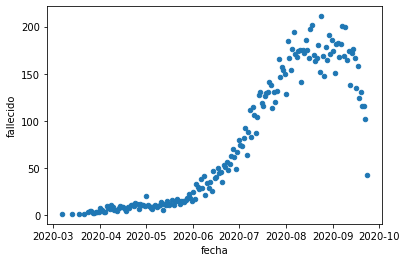

In [3]:
dailyDeathsMS.plot(kind='scatter', x='fecha', y='fallecido')

Un estudio realizado por Yoshiro Nishimoto y Kenichi Inoue de la Universidad de Kobe sobre curvas de ajuste para el desempeño del COVID-19 ha demostrado resultados satisfactorios. De esta manera, los autores han podido predecir el pico de casos en distintos lugares del mundo. Como la metodología de evaluación de contagiados cambia a medida que avanza la epidemia, nos hemos centrado en los fallecimientos. De esta manera podemos analizar las curvas bajo un mismo criterio. Para más información sobre la curva de ajuste a utilizar, pueden visitar el paper correspondiente en: https://www.medrxiv.org/content/10.1101/2020.07.02.20144899v2

La curva de ajuste a utilizar en particular es la siguiente:

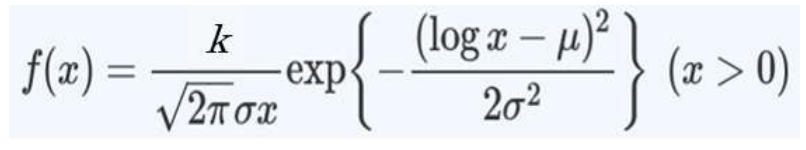

Definimos en la siguiente función "log_normal" el comportamiento de la curva y fijamos 3 parámetros de ajuste: a, b y c. La particularidad de esta curva, tal como se puede observar en el gráfico inferior, es una pendiente de subida rápida y un descenso lento. Este comportamiento se ajusta considerablemente bien a las curvas de infección y decesos del COVID-19 y otras epidemias. Nuevamente, existe más información al respecto en el paper citado previamente.

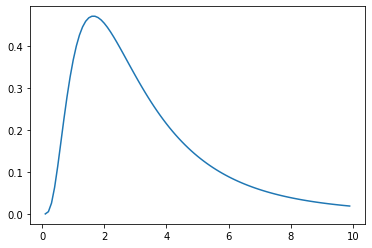

In [4]:
# Define fitting curve
import matplotlib.pyplot as plt

def log_normal(t, a, b, c):
    y = (a/t)*np.exp(-((np.log(t)-b)**2)/c**2)
    return y

time = np.arange(0.1,10, 0.1)
y = [log_normal(t, 1, 1, 1) for t in time]
plt.plot(time, y)

In [5]:
# convert dates to Date of Year format
dailyDeathsMS['DoY'] = dailyDeathsMS.fecha.apply(lambda x: x.strftime('%j'))
dailyDeathsMS.tail(14)

,fecha,fallecido,DoY
174,2020-09-10,165,254
175,2020-09-11,174,255
176,2020-09-12,138,256
177,2020-09-13,172,257
178,2020-09-14,176,258
179,2020-09-15,167,259
180,2020-09-16,135,260
181,2020-09-17,158,261
182,2020-09-18,124,262
183,2020-09-19,131,263


Tal como se observa en la tabla anterior y la figura del gráfico de diseprsión, el número de fallecidos disminuye abruptamente para los últimos días. Este es un comportamiento que se repite en todas las actualizaciones del dataset del Ministerio de Salud y está relacionado con la demora en la carga de datos. El análisis de la demora requiere el desarrollo de un apartado particular y se encuentra fuera del análisis de este informe. De todas maneras, en la siguiente página se puede encontrar información al respecto: https://covidstats.com.ar/reportediario

A modo de ejemplo, para el día de análisis de los datos, 23 de Septiembre, la carga de fallecimientos en función de la fecha de deceso es la siguiente:
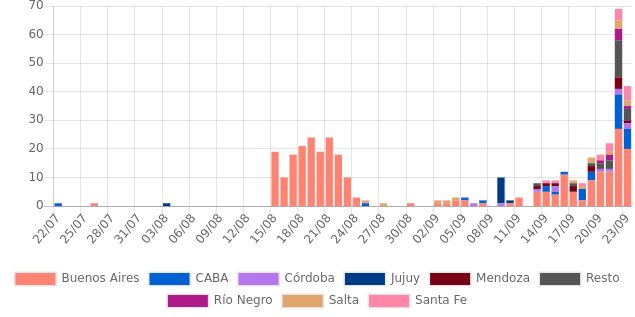

Para la provincia de Buenos Aires, existe una demora de prácticamente un mes en la carga de datos, algo consistente, se repite diariamente este fenómeno. Lamentablemente esto impacta negativamente en la calidad de las predicciones del pico de la pandemia en Argentina, al menos de esta primer ola de contagios y fallecidos.

Mas allá de este fenómeno de demora para la provincia de Buenos Aires, podemos observar que la carga de datos suele reunir las incidencias de los últimos 5 días. Es por esto que vamos a quitar estos días para hacer el análisis correspondiente.

# Ajuste de curva Log Normal

In [6]:
# Cast column values and set first day as #1
dailyDeathsMS['DoY'] = dailyDeathsMS.DoY.astype(int)
dailyDeathsMS['DoS'] = dailyDeathsMS.DoY.apply(lambda x: x - 66)
dailyDeathsMS.head()

# Normalize values to estimate fitting correctly and delete last days from analysis
x_data = dailyDeathsMS.DoS[:-5]
y_data = dailyDeathsMS.fallecido[:-5]
xdata =x_data/max(x_data)
ydata =y_data/max(y_data)

In [7]:
# Find best parameters which optimizes the curve
from scipy.optimize import curve_fit

popt, pcov = curve_fit(log_normal, xdata, ydata)
print(popt)

[ 0.768757   -0.0369035   0.42818704]


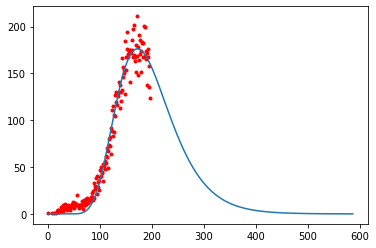

Max number of cases on DoY 238.48 with 176.19904822487158 deaths


In [8]:
# Generate the fitting curve points
xfit = np.arange(0.005, 3, 0.005)
yfit = [log_normal(x, *popt) for x in xfit]

# Convert to numpy array to multiply it by a constant
xfit = np.asarray(xfit)
yfit = np.asarray(yfit)

# Re-scale arrays
xdata = xdata * max(x_data)
xfit = xfit * max(x_data)
ydata = ydata * max(y_data)
yfit = yfit * max(y_data)

plt.plot(xdata, ydata, 'r.')
plt.plot(xfit, yfit)
plt.show()

# Find the curve peak
maxNumCases = max(yfit)
dayMaxCases = xfit[np.where(yfit == maxNumCases)][0]
print("Max number of cases on DoY {} with {} deaths".format(dayMaxCases+66, maxNumCases))

<h2> Datos de COVID Stats AR </h2>

A modo de referencia, es interesante analizar los resultados teniendo en cuenta los datos publicados en COVID Stats. Podemos exportar los datos a un csv accediendo directamente a https://covidstats.com.ar/exportar

In [9]:
covidStats = pd.read_csv("2020-09-23_Nacional.csv", skiprows=3)
covidStats.head()

,fecha,fallecidos,terapia,casos_dx,diagnosticos,internados,casos_fis,casos_fis_ajustada,casos_fa
0,2020-01-01,0,0,1,3,1,0,0,0
1,2020-01-02,0,0,0,0,0,1,1,0
2,2020-01-03,0,0,0,0,0,0,0,0
3,2020-01-04,0,0,0,0,0,0,0,0
4,2020-01-05,0,0,0,0,0,0,0,0


Limpiamos los datos para ajustarlos al formato de interés

In [10]:
covidStats['fecha'] = pd.to_datetime(covidStats['fecha'], format='%Y-%m-%d')
dailyDeathsCS = covidStats.loc[covidStats.fallecidos > 0]
dailyDeathsCS['DoY'] = [date.strftime('%j') for date in dailyDeathsCS.fecha]
dailyDeathsCS['DoY'] = dailyDeathsCS.DoY.astype(int)
dailyDeathsCS['DoS'] = [(i - 66) for i in dailyDeathsCS.DoY]
dailyDeathsCS = dailyDeathsCS[['fecha', 'fallecidos', 'DoY', 'DoS']]

<ipython-input-10-0a4586df4816>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dailyDeathsCS['DoY'] = [date.strftime('%j') for date in dailyDeathsCS.fecha]
<ipython-input-10-0a4586df4816>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dailyDeathsCS['DoY'] = dailyDeathsCS.DoY.astype(int)
<ipython-input-10-0a4586df4816>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

In [11]:
dailyDeathsCS.tail(14)

,fecha,fallecidos,DoY,DoS
253,2020-09-10,165,254,188
254,2020-09-11,174,255,189
255,2020-09-12,138,256,190
256,2020-09-13,172,257,191
257,2020-09-14,176,258,192
258,2020-09-15,167,259,193
259,2020-09-16,135,260,194
260,2020-09-17,158,261,195
261,2020-09-18,124,262,196
262,2020-09-19,131,263,197


Aparentemente los datos son los mismos, veamos qué predicción obtenemos a partir del ajuste con la curva Log Normal

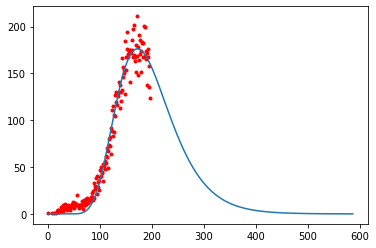

Max number of cases on day 238.48 with 176.19904822487158 deaths


In [12]:
x_data = dailyDeathsCS.DoS[:-5]
y_data = dailyDeathsCS.fallecidos[:-5]
xdata =x_data/max(x_data)
ydata =y_data/max(y_data)

popt, pcov = curve_fit(log_normal, xdata, ydata)

# Generate fitting curve
xfit = np.arange(0.005, 3, 0.005)
yfit = [log_normal(x, *popt) for x in xfit]

# Convert to numpy array to multiply it by a constant
xfit = np.asarray(xfit)
yfit = np.asarray(yfit)

# Re-scale arrays
xdata = xdata * max(x_data)
xfit = xfit * max(x_data)
ydata = ydata * max(y_data)
yfit = yfit * max(y_data)

plt.plot(xdata, ydata, 'r.')
plt.plot(xfit, yfit)
plt.show()

maxNumCases = max(yfit)
dayMaxCases = xfit[np.where(yfit == maxNumCases)][0]
print("Max number of cases on day {} with {} deaths".format(dayMaxCases+66, maxNumCases))

Evidentemente, los resultados son los mismos, esto es interesante ya que puede usarse el dataset de COVID Stats alternativamente para el modelaje de la curva, siendo esta base de datos mucho más liviana ya que la información es previamente procesada.

<h2> Ajustes con la función logística </h2>

Es común observar ajustes de infección y muertes realizados con esta curva, ya que su comportamiento muestra un punto de inflexión donde la curva cambia de velocidad. Este punto corresponde con el pico de contagios o muertes tal como suele observarse en la distribución de casos diarios.

Para utilizar esta curva en particular es importante primero, tener una columna de los casos acumulados. Como las curvas de interés son analizadas en un marco temporal diario, acumularemos dichos resultados de dicha manera.

Definimos entonces, una función para poder acumular los casos en una nueva columna "fall_tot"

In [13]:
def acum_deaths(acumArray):
    acum = []
    count = 0
    
    for f in acumArray:
        count = f + count
        acum.append(count)

    return acum

dailyDeathsMS['fall_tot'] = acum_deaths(dailyDeathsMS.fallecido)
dailyDeathsCS['fall_tot'] = acum_deaths(dailyDeathsCS.fallecidos)

Definimos la función logística, también conocida como función sigmoid

In [14]:
def sigmoid(x, Beta_1, Beta_2):
     y = 1 / (1 + np.exp(-Beta_1*(x-Beta_2)))
     return y

10.316829643060558 0.7722192308033262


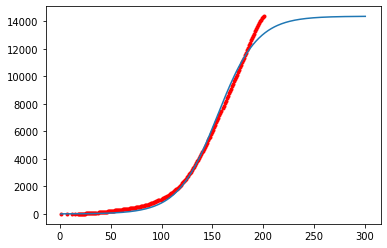

<Figure size 1440x720 with 0 Axes>

In [15]:
x_data = dailyDeathsMS.DoS
y_data = dailyDeathsMS.fall_tot
xdata =x_data/max(x_data)
ydata =y_data/max(y_data)

popt, pcov = curve_fit(sigmoid, xdata, ydata)

print(*popt)

xfit = np.arange(0.005, 1.5, 0.005)
yfit = [sigmoid(x, *popt) for x in xfit]

# Convert to numpy array to multiply it by a constant
xfit = np.asarray(xfit)
yfit = np.asarray(yfit)

# Re-scale arrays
xdata = xdata * max(x_data)
xfit = xfit * max(x_data)
ydata = ydata * max(y_data)
yfit = yfit * max(y_data)

plt.plot(xdata, ydata, 'r.')
plt.plot(xfit, yfit)
fig = plt.figure(figsize=(20,10))
plt.show()

La curva muestra que aún teniendo en cuenta la baja carga de datos de los últimos días, problema que mencionamos en el principio del apartado, no se evidencia una clara inflexión de la tendencia, aún con el mejor fit posible. Esto implica que aún es muy pronto para estimar que los casos diarios están perdiendo velocidad. 

Existe un estudio de la Escuela de Ingeniería de Información de la Universidad de Geociencias de China que realiza predicciones basada en este modelo de función logística. Probablemente un artículo posterior muestre el resultado de la implementación del modelo sugerido. Para mas información, se puede consultar el siguiente paper https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7328553/

# Mapa de Densidad de Fallecidos por Departamento

Analizaremos en este apartado la distribución geográfica de fallecidos. En particular estamos interesados en el comportamiento de la pandemia en zonas densamente pobladas, donde estimamos que puede existir una mayor velocidad de contagio.

Comenzaremos seleccionando los campos relevantes del dataset del Ministerio de Salud. Lamentablemente, no disponemos de datos con mayor granularidad que la clasificación de cada caso por departamento de cada provincia. Esto incluye a su vez, las comunas de CABA.

In [16]:
classFilter = (df.fallecido == 1) & (df.clasificacion_resumen == 'Confirmado')
deadMS = df.loc[classFilter]
deadMS = deadMS[['residencia_provincia_nombre', 'residencia_departamento_nombre', 'fallecido', 'residencia_provincia_id',
    'residencia_departamento_id']]

<h2> Data Cleaning </h2>

Vamos a generar un campo con un código de identificación único para cada departamento, basado en la nomenclatura utilizada por el INDEC y el archivo con puntos geográficos que utilizaremos posteriormente.

In [17]:
def make_in1(row):
    idProv = row[3]
    idDpto = row[4]
    return(f'{idProv:02}{idDpto:03}')


deadMS['in1'] = [make_in1(row) for row in deadMS.values]

Algunas provincias no disponen del departamento de residencia del fallecido. El criterio utilizado es repartir los casos proporcionalmente en todas las demás comunas o departamentos. Si bien la decisión puede ser cuestionada, es una manera de no perder datos y distribuir los mismos de manera balanceada.

In [18]:
provSinEsp = deadMS.loc[deadMS.residencia_departamento_nombre == 'SIN ESPECIFICAR']\
                   .groupby('residencia_provincia_nombre').sum().index

provSinEsp = list(provSinEsp)

if 'SIN ESPECIFICAR' in provSinEsp:
    # Remove from provinces list
    provSinEsp.remove('SIN ESPECIFICAR')
    
    try:
        # Delete all ocurrencies from dataset where not province specified
        sinEsp = deadMS[deadMS['residencia_provincia_nombre'] == 'SIN ESPECIFICAR'].index
        deadMS.drop(sinEsp, inplace=True)
    except:
        print('province sin especificar not found')

deadMSGrouped = deadMS.groupby(['residencia_provincia_nombre', 'residencia_departamento_nombre', 'in1'])\
                      .sum().sort_values('fallecido', ascending=False)        

for provincia in provSinEsp:

    totDeadProv = deadMSGrouped.loc[provincia, ].sum().fallecido
    notSpecProv = deadMSGrouped.loc[provincia, 'SIN ESPECIFICAR', ].fallecido[0]
    
    realDeadProv = totDeadProv - notSpecProv
    
    for i, value in enumerate(deadMSGrouped.loc[provincia, ].values):
        
        val = value[0]
        
        index = deadMSGrouped.loc[provincia, ].index[i]
        if  index[0] != 'SIN ESPECIFICAR':
            # Add proportionally the values in 'SIN ESPECIFICAR'
            val = (val/realDeadProv) * (notSpecProv) + val
           
            deadMSGrouped.loc[provincia, index[0], index[1]][0] = int(val)
            
    deadMSGrouped.drop((provincia, 'SIN ESPECIFICAR'), inplace=True)

    
deadMSGrouped.reset_index(inplace=True)


<ipython-input-18-a10a4065f308>:22: PerformanceWarning: indexing past lexsort depth may impact performance.
  totDeadProv = deadMSGrouped.loc[provincia, ].sum().fallecido
<ipython-input-18-a10a4065f308>:23: PerformanceWarning: indexing past lexsort depth may impact performance.
  notSpecProv = deadMSGrouped.loc[provincia, 'SIN ESPECIFICAR', ].fallecido[0]
<ipython-input-18-a10a4065f308>:27: PerformanceWarning: indexing past lexsort depth may impact performance.
  for i, value in enumerate(deadMSGrouped.loc[provincia, ].values):
<ipython-input-18-a10a4065f308>:31: PerformanceWarning: indexing past lexsort depth may impact performance.
  index = deadMSGrouped.loc[provincia, ].index[i]
/home/augusto/.local/lib/python3.8/site-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)


Carguemos ahora los datos de población por cada departamento. Los datos se pueden encontrar en la página del Indec, luego se exporta una planilla de cálculos. En el repositorio hay un script para tomar los datos de dicha planilla y generar el csv correspondiente. https://redatam.indec.gob.ar/argbin/RpWebEngine.exe/PortalAction?&MODE=MAIN&BASE=CPV2010B&MAIN=WebServerMain.inl&_ga=2.177965477.1629507683.1526925251-993948438.1526925251

Los parámetros utilizados en la generación del documento son: edades quinquenales, departamento/partido, y el total de toda la base.

In [19]:
def get_population(code):
    row = pobDeptos.loc[pobDeptos.in1 == code]
    try:
        return(row.iloc[0, 2])
    except:
        print(f'Population not found for {code}')

pobDeptos = pd.read_csv('poblacion_dpto.csv')
# Standarize codes to 5 digits with zero padding
pobDeptos['in1'] = [f'{code:05}' for code in pobDeptos.in1]

# Clean dataset and free some resources
deadMS = deadMSGrouped.drop(columns=['residencia_provincia_id','residencia_departamento_id'])
del(deadMSGrouped)
deadMS.rename(columns={'residencia_provincia_nombre': 'provincia', 
                       'residencia_departamento_nombre': 'departamento',
                       'fallecido': 'fallecidos'},
              inplace=True)

deadMS['poblacion'] = [get_population(in1) for in1 in deadMS.in1]

deadMS['deathRatio'] = [(fallecidos*10000/poblacion) for fallecidos, poblacion in \
                        zip(deadMS.fallecidos, deadMS.poblacion)]
deadMS.head()

Population not found for 38182
Population not found for 06466


,provincia,departamento,in1,fallecidos,poblacion,deathRatio
0,Buenos Aires,La Matanza,06427,1122,1775816.0,6.318222
1,Buenos Aires,Quilmes,06658,553,582943.0,9.486348
2,Buenos Aires,Almirante Brown,06028,454,552902.0,8.211220
3,Buenos Aires,Lanús,06434,413,459263.0,8.992669
4,Buenos Aires,General San Martín,06371,403,414196.0,9.729693


In [20]:
# Data cleaning of wrong inputs

deptos = ['06466', '38182']

for d in deptos:
    print(deadMS.loc[deadMS.in1 == d].index)

# 272 258
deadMS.drop(index=[272, 258], inplace=True)

Int64Index([272], dtype='int64')
Int64Index([258], dtype='int64')


Finalmente, generemos un listado de los departamentos con mayor cantidad de muertos por 10 mil habitantes.

In [21]:
deadMS.sort_values('deathRatio', ascending=False).head(30)

,provincia,departamento,in1,fallecidos,poblacion,deathRatio
26,CABA,COMUNA 07,02007,396,220591.0,17.951775
106,Río Negro,Conesa,62028,12,7069.0,16.975527
29,CABA,COMUNA 04,02004,338,218245.0,15.487182
34,CABA,COMUNA 01,02001,291,205886.0,14.134035
125,Buenos Aires,Pellegrini,06616,8,5887.0,13.589264
40,CABA,COMUNA 03,02003,228,187537.0,12.157601
45,CABA,COMUNA 09,02009,187,161797.0,11.557693
38,Jujuy,Ledesma,38035,90,81790.0,11.003790
5,Buenos Aires,Avellaneda,06035,368,342677.0,10.738976
42,CABA,COMUNA 08,02008,200,187237.0,10.681649


Graficamos los departamentos con la capa de densidad de muertos cada 10 mil habitantes. El archivo GeoJson puede ser descargado de https://ramsac.ign.gob.ar/api/v1/capas-sig/Geodesia+y+demarcaci%C3%B3n/L%C3%ADmites/departamento/json

Sin embargo, la codificación no es totalmente compatible con la utilizada por INDEC. Algunos códigos, en particular los correspondientes a CABA no coinciden y han tenido que ser editados a mano. Se puede encontrar el GeoJson utilizado en la carpeta /extras

Tener en cuenta que renderizar el mapa consume muchos recursos. El requisito es tener al menos <b> 1GB de RAM disponible.</b>

In [22]:
import folium

In [23]:

argMap = folium.Map(
         location=[-40, -61],
         zoom_start=4  # Limited levels of zoom for free Mapbox tiles.
)

departments = 'departamento.json'


folium.Choropleth(
    geo_data=departments,
    name='choropleth',
    data=deadMS,
    columns=['in1', 'deathRatio'],
    key_on='properties.in1',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    nan_fill_color='white',
    nan_fill_opacity=0.7,
    legend_name='Fallecidos cada 10 mil habitantes'
).add_to(argMap)


#argMap <-- uncomment if you want to display it in the notebook, otherwise it will be saved to disk
argMap.save('fallecidosArg.html')